# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [ ]:
!pip install gym

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

   """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.

    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        #atn : the choice of the action is random + probability distribution
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, _,_ = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [45]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((14, 8, False), 1, -1.0)]
[((13, 9, True), 0, -1.0)]
[((14, 2, False), 1, 0.0), ((21, 2, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

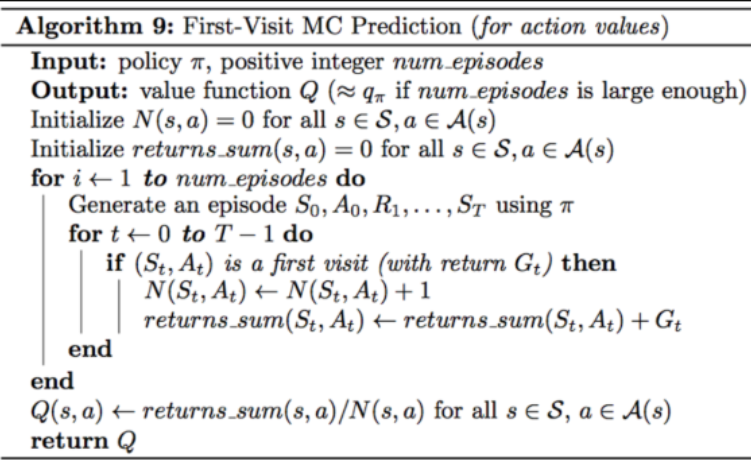

In [40]:
#atn
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_set = set()
     
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()


        ## TODO: complete the function
        episode = generate_episode(env)
        episode_state_action_list = []
        for j_time_step in range(0,len(episode)):
            state = episode[j_time_step][0]
            action = episode[j_time_step][1]
            return_sum = 0
            if (state,action) in episode_state_action_list:
                continue
            else:
                episode_state_action_list.append((state,action))
                state_action_set.add((state,action))
                N[state][action]+=1                
                for k_time_step in range(j_time_step, len(episode)):
                    return_sum += episode[k_time_step][2]*(gamma**(k_time_step-j_time_step))
                returns_sum[state][action]+=return_sum
    state_action_list = list(state_action_set)
    for pair in state_action_list:
        Q[pair[0]][pair[1]] =returns_sum[pair[0]][pair[1]]/N[pair[0]][pair[1]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [41]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

In [42]:
Q

defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>()>,
            {(16, 1, False): array([-0.75292865, -0.73047859]),
             (16, 7, True): array([-0.54545455, -0.17873303]),
             (21, 1, False): array([ 0.63679469, -1.        ]),
             (19, 4, True): array([0.39827586, 0.07096774]),
             (13, 9, False): array([-0.56332931, -0.53137711]),
             (14, 10, True): array([-0.5883905 , -0.35701164]),
             (12, 2, False): array([-0.28442438, -0.46374269]),
             (21, 2, True): array([ 0.98114286, -0.11659193]),
             (18, 10, False): array([-0.23492605, -0.72663858]),
             (15, 6, True): array([-0.22522523, -0.10328638]),
             (18, 4, False): array([ 0.17325581, -0.67138409]),
             (17, 2, False): array([-0.17241379, -0.64886952]),
             (4, 8, False): array([-0.44186047, -0.4679803 ]),
             (18, 9, True): array([-0.19685039, -0.31318681]),
             (11, 6, False): array([-0.104

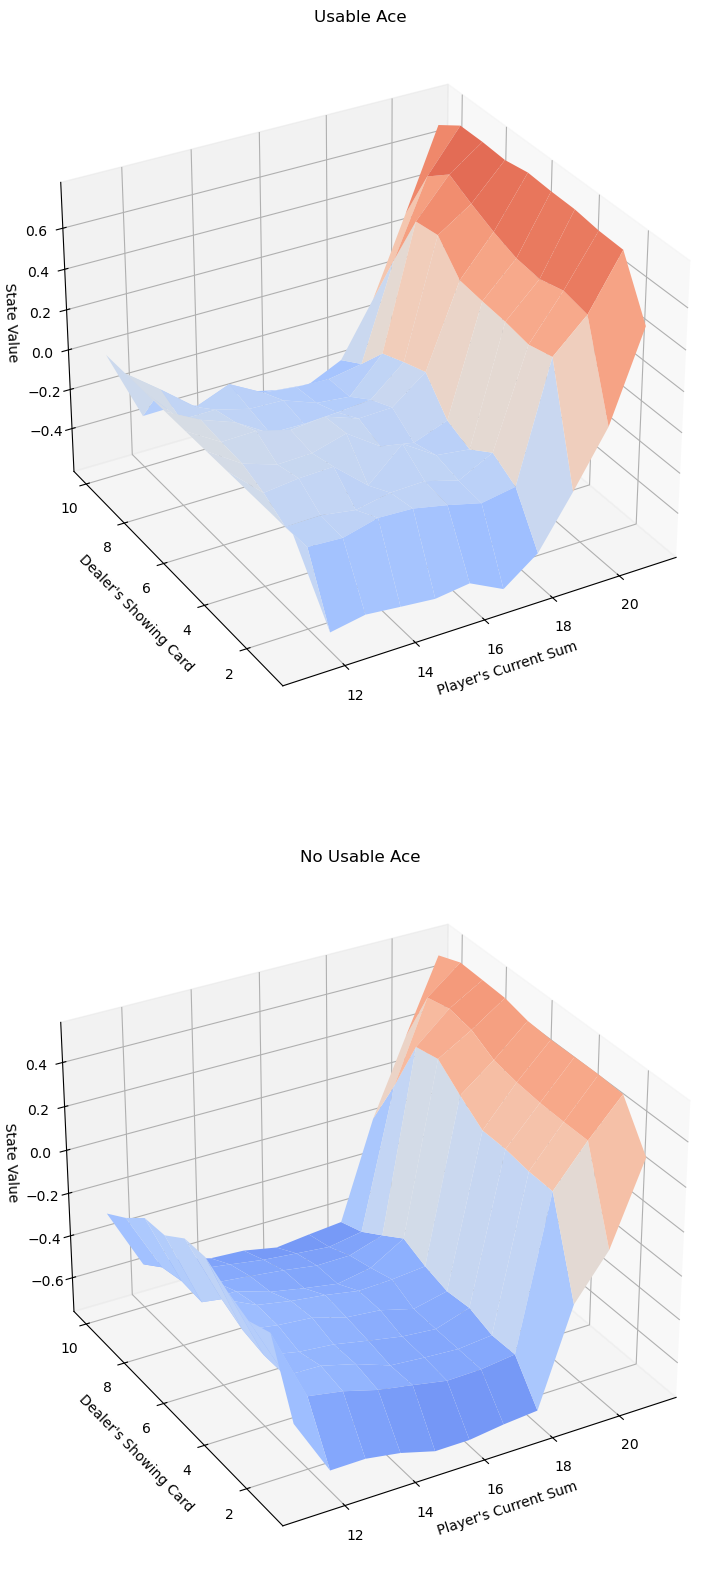

In [43]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [44]:
V_to_plot

{(16, 1, False): -0.7349686010359915,
 (16, 7, True): -0.25207733443027563,
 (21, 1, False): 0.3094357515410147,
 (19, 4, True): 0.33281423804226923,
 (13, 9, False): -0.5377675475517432,
 (14, 10, True): -0.40328740828589754,
 (12, 2, False): -0.4278790278932848,
 (21, 2, True): 0.7615959000640614,
 (18, 10, False): -0.6282960744763846,
 (15, 6, True): -0.12767415302626572,
 (18, 4, False): -0.50245611148046,
 (17, 2, False): -0.5535783728947294,
 (4, 8, False): -0.4627563294764578,
 (18, 9, True): -0.289919529289608,
 (11, 6, False): -0.03526677987308964,
 (16, 1, True): -0.508983367878267,
 (7, 1, False): -0.6485787060621497,
 (20, 6, True): 0.5478089774645178,
 (12, 10, False): -0.5571472494362184,
 (14, 7, False): -0.5110894152272419,
 (9, 3, False): -0.2230459275099746,
 (19, 1, False): -0.2589310642823905,
 (13, 2, False): -0.4553642168183671,
 (21, 1, True): 0.48881519675460516,
 (16, 6, False): -0.5101399788889911,
 (14, 9, True): -0.19936507936507936,
 (18, 10, True): -0.3627

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

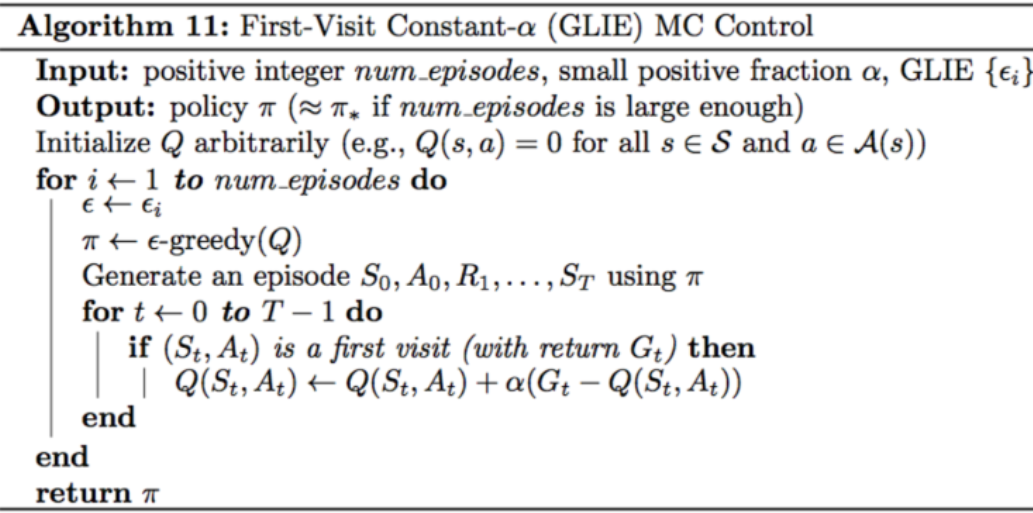

In [8]:
def generate_episode_from_glie_and_pi(bj_env, epsilon, Q):
    episode = []
    state = bj_env.reset()[0]

    while True:
        # pi
        if Q[state][0]==Q[state][1]:
            action = np.random.choice(np.arange(2))
        else:
            probs = [1-epsilon+epsilon/env.action_space.n, epsilon/env.action_space.n] if Q[state][0]>Q[state][1]\
                else [ epsilon/env.action_space.n, 1-epsilon+epsilon/env.action_space.n]
            action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, _,_ = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [40]:
#test episode generation
epsilon = 0.4
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))
for num in range(3):
    episode = generate_episode_from_glie_and_pi(env, epsilon,Q)
    print(episode)
Q

[((17, 2, False), 0, -1.0)]
[((19, 10, False), 0, 0.0)]
[((20, 10, True), 0, 1.0)]


defaultdict(<function __main__.<lambda>()>,
            {(17, 2, False): array([0., 0.]),
             (19, 10, False): array([0., 0.]),
             (20, 10, True): array([0., 0.])})

In [9]:
def mc_control(env,  num_episodes, generate_episode, alpha, gamma=1.0):
    
    # initialize empty dictionary of arrays
    nA = env.action_space.n
    returns_sum = defaultdict(lambda: np.zeros(nA))
    Q = defaultdict(lambda: np.zeros(nA))
    policy = defaultdict(lambda: np.zeros(1))
    # state_action_set = set()
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        epsilon = 1/i_episode
        min_epsilon = 0.5
        epsilon = max(epsilon, min_epsilon)
        episode = generate_episode(env, epsilon, Q)
        episode_state_action_list = []
        for j_time_step in range(0,len(episode)):
            state = episode[j_time_step][0]
            action = episode[j_time_step][1]
            return_sum = 0
            if (state,action) in episode_state_action_list:
                continue
            else:
                episode_state_action_list.append((state,action))
                # state_action_set.add((state,action))
                # N[state][action]+=1                
                for k_time_step in range(j_time_step, len(episode)):
                    return_sum += episode[k_time_step][2]*(gamma**(k_time_step-j_time_step))
                # returns_sum[state][action]+=return_sum
                Q[state][action] = Q[state][action] + alpha*(return_sum - Q[state][action])
                # returns_sum[pair[0]][pair[1]]/N[pair[0]][pair[1]]
    # state_action_list = list(state_action_set)
    for state, actions in Q.items():
        if actions[0] == actions[1]:
            policy[state] = np.random.choice(np.arange(2))
        else:
            policy[state] = 0 if actions[0]>actions[1] else 1
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [10]:
# obtain the estimated optimal policy and action-value function
# epsilon = 0.4
num_episodes = 500000
alpha = 0.3
policy, Q = mc_control(env, num_episodes,generate_episode_from_glie_and_pi, alpha )

Episode 1000/500000.

D:\Users\anhtu\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 500000/500000.

In [10]:
Q

defaultdict(<function __main__.mc_control.<locals>.<lambda>()>,
            {(12, 7, False): array([-0.84634186, -0.99240303]),
             (15, 10, False): array([-0.99992206, -0.91594249]),
             (19, 10, False): array([-0.0256237 , -0.99666364]),
             (18, 4, False): array([ 0.00784933, -0.95259461]),
             (16, 9, False): array([-0.99864107, -0.99986195]),
             (19, 9, False): array([ 0.20507079, -0.83193   ]),
             (16, 3, False): array([-0.99848154,  0.62288682]),
             (19, 3, False): array([ 0.49303197, -0.83193   ]),
             (9, 3, False): array([-0.95165333, -0.33337164]),
             (11, 8, False): array([-0.87050608,  0.71275157]),
             (21, 8, False): array([0.84559952, 0.        ]),
             (7, 7, False): array([-0.96060833, -0.69775571]),
             (6, 2, False): array([-0.96211005, -0.15811654]),
             (11, 2, False): array([-0.91738161,  0.79796548]),
             (15, 2, False): array([-0.9988

In [11]:
policy

defaultdict(<function __main__.mc_control.<locals>.<lambda>()>,
            {(12, 7, False): 0,
             (15, 10, False): 1,
             (19, 10, False): 0,
             (18, 4, False): 0,
             (16, 9, False): 0,
             (19, 9, False): 0,
             (16, 3, False): 1,
             (19, 3, False): 0,
             (9, 3, False): 1,
             (11, 8, False): 1,
             (21, 8, False): 0,
             (7, 7, False): 1,
             (6, 2, False): 1,
             (11, 2, False): 1,
             (15, 2, False): 1,
             (20, 2, False): 0,
             (14, 10, False): 1,
             (16, 10, False): 1,
             (13, 2, False): 1,
             (17, 10, False): 0,
             (21, 5, True): 0,
             (21, 5, False): 0,
             (10, 2, False): 1,
             (18, 7, False): 0,
             (18, 1, False): 0,
             (15, 3, False): 0,
             (18, 6, False): 0,
             (6, 7, False): 1,
             (9, 7, False): 1,
         

Next, we plot the corresponding state-value function.

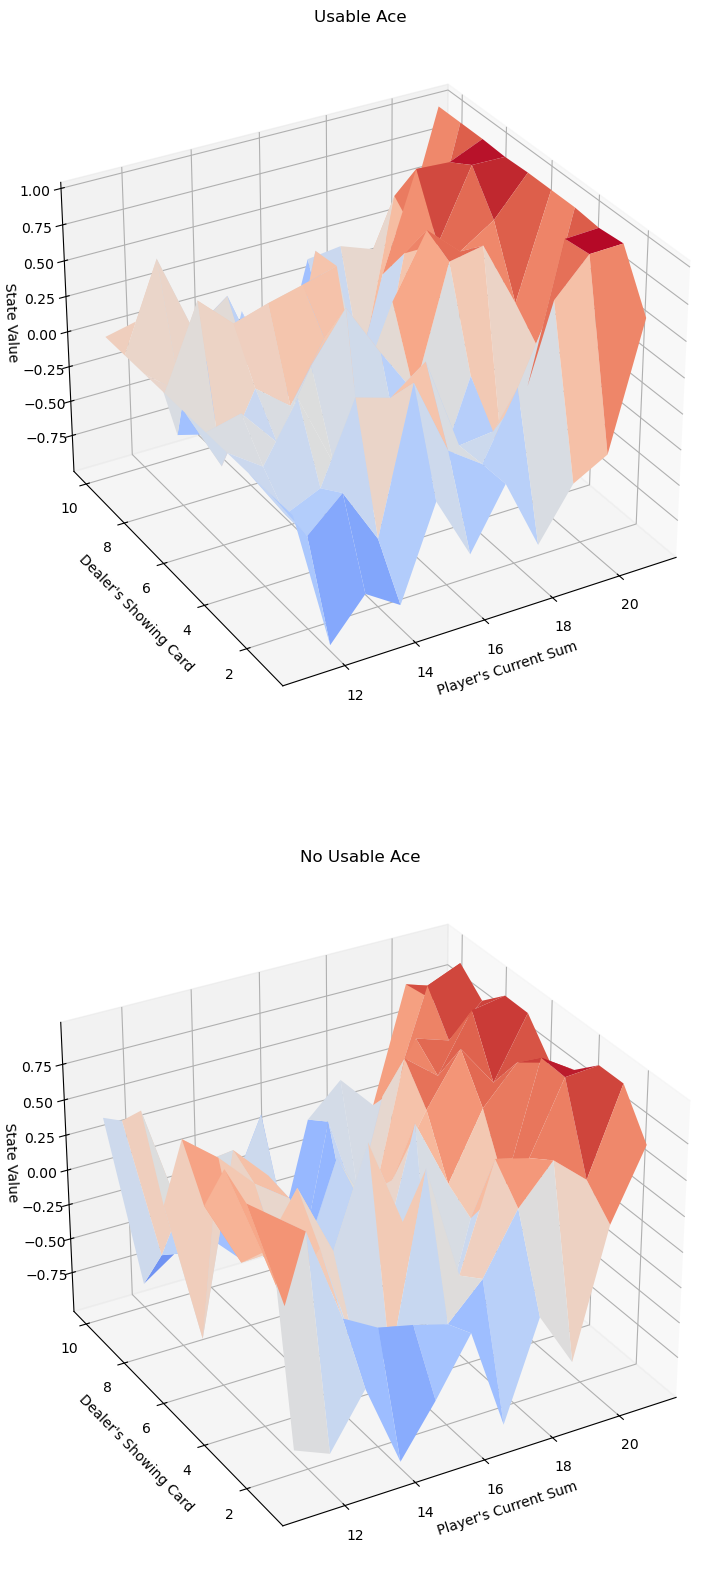

In [12]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

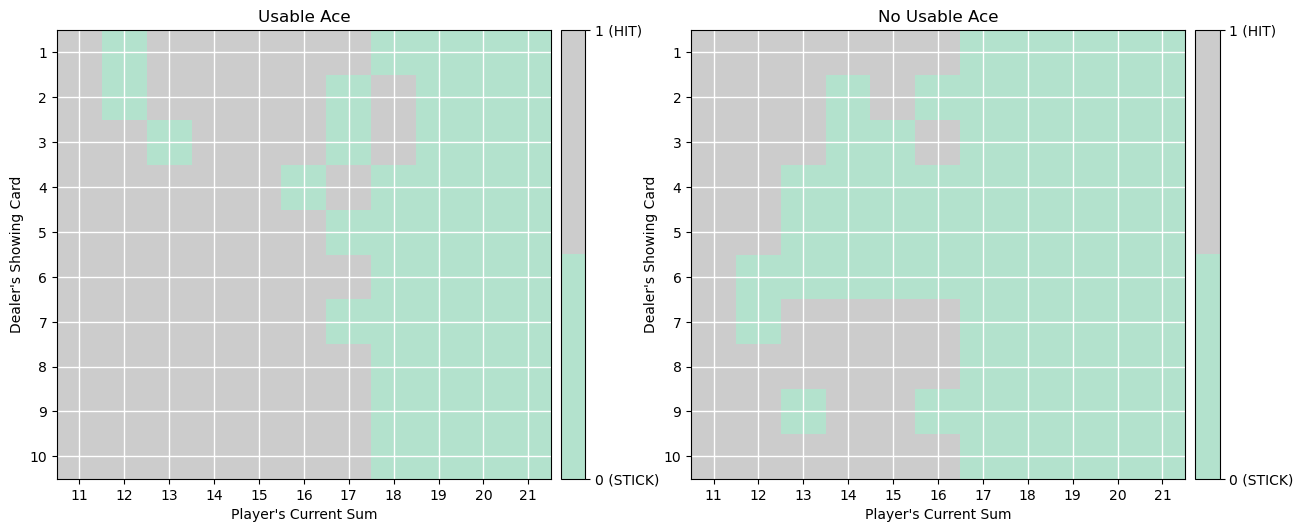

In [13]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)